## Import the Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import re
from bs4 import BeautifulSoup    # for the parsing the HTML content in text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping   # to early stop model training id loss is increase 
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model


## Read Dataset 


In [2]:
df = pd.read_csv("Reviews.csv" , nrows = 50000)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
#  Drop duplicates and NA values 

df.drop_duplicates(subset=['Text'] , inplace = True)  #droping duplicate
df.dropna(axis = 0 , inplace = True) # dropping na

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46250 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      46250 non-null  int64 
 1   ProductId               46250 non-null  object
 2   UserId                  46250 non-null  object
 3   ProfileName             46250 non-null  object
 4   HelpfulnessNumerator    46250 non-null  int64 
 5   HelpfulnessDenominator  46250 non-null  int64 
 6   Score                   46250 non-null  int64 
 7   Time                    46250 non-null  int64 
 8   Summary                 46250 non-null  object
 9   Text                    46250 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.9+ MB


## Preprocessing 


Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.



In [5]:
# Here is the dictionary that we will use for expanding the contractions:

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


#### We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words



In [6]:
## Define the function to clear all data 

stop_words = set(stopwords.words('english')) 


def text_cleaner(text, num):
    new_s = text.lower()
    new_s = BeautifulSoup(new_s,"lxml").text
    new_s = re.sub(r'\([^)]*\)' , '' , new_s)
    new_s = re.sub('"' , '',new_s)
    new_s = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_s.split(" ")])
    new_s = re.sub(r"'s\b","",new_s)
    new_s = re.sub("[^a-zA-z]" , " " , new_s)
    new_s = re.sub('[m]{2,}', 'mm' , new_s)
    
    if num==0:
        tokens = [w for w in new_s.split() if not w in stop_words]
    else:
        tokens = new_s.split()
    long_words = []
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [7]:
#  call the function ... to clean text in df 

cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [8]:
cleaned_text[:2]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [9]:
df['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [10]:
#  call function to clean summery in df

cleaned_summery = []
for t in df['Summary']:
    cleaned_summery.append(text_cleaner(t,0))

C:\Users\Administrator\anaconda3\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: "..." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [11]:
df['Summary'][:5]

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [12]:
cleaned_summery[:5]

['good quality dog food',
 'advertised',
 'delight says',
 'cough medicine',
 'great taffy']

In [13]:
df['cleaned_Summery'] = cleaned_summery
df['cleaned_Text'] = cleaned_text

In [14]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_Summery,cleaned_Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,good quality dog food,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,advertised,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,delight says,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,cough medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy,great taffy great price wide assortment yummy ...


In [15]:
df.replace('' , np.nan , inplace = True)
df.dropna(axis = 0 , inplace = True)

now we will analysis the length od review and summary of get an overall idea about the distributionof length of text 

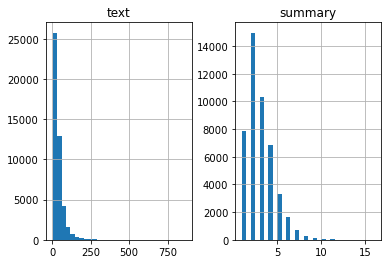

In [16]:
text_word_count = []
summary_word_count = []

for i in df['cleaned_Text']:
    text_word_count.append(len(i.split()))
    

for i in df['cleaned_Summery']:
    summary_word_count.append(len(i.split()))    
    
length_df = pd.DataFrame({'text' : text_word_count , 'summary' : summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
length_df


,text,summary
0,23,4
1,18,1
2,39,2
3,17,2
4,13,2
...,...,...
46092,21,3
46093,21,4
46094,11,4
46095,15,3


In [18]:
cnt = 0 
for i in df['cleaned_Summery']:
    if (len(i.split())<=8):
        cnt = cnt+1
print(cnt/len(df['cleaned_Summery']))

0.9946417337353841


we observe 99% of the summaries have length below 8 s we can fix the max length of summary ti 8
and let fix the max length of review 30

In [19]:
max_text_len=30
max_summary_len=8
# now select the reviews and summaries whose length falls below or equal to max_text_len and max_summary_len

In [20]:
cleaned_text = np.array(df['cleaned_Text'])
cleaned_summary = np.array(df['cleaned_Summery'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df1 = pd.DataFrame({'text':short_text , 'summary' : short_summary})

Remember to add the START and END special tokens at the beginning and end of the summary. Here, I have chosen ### sostok and ### eostok as START and END tokens(because in decoder part we have to add 2 extra tocken that decoder knows that where to start and end process)

#### Note: Be sure that the chosen special tokens never appear in the summary



In [21]:
df1['summary'] = df1['summary'].apply(lambda x : 'sostok ' + x + ' eostok')

In [22]:
df1['summary']

0                 sostok good quality dog food eostok
1                            sostok advertised eostok
2                        sostok cough medicine eostok
3                           sostok great taffy eostok
4           sostok great good expensive brands eostok
                             ...                     
25685                 sostok grown really like eostok
25686         sostok healthy snack great price eostok
25687    sostok raw revolution hazelnut cashew eostok
25688          sostok fantastic chew carefully eostok
25689                     sostok tasty healthy eostok
Name: summary, Length: 25690, dtype: object

In [23]:
from sklearn.model_selection import train_test_split
x_train , x_val , y_train , y_val = train_test_split(np.array(df1['text']),np.array(df1['summary']),test_size=0.1,random_state=0,shuffle=True)

In [24]:
len(x_train) , len(x_val),len(y_train) , len(y_val)

(23121, 2569, 23121, 2569)

## Preparing tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

## Text Tokenizer


In [25]:
#prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [26]:
x_tokenizer.word_counts.items()

odict_items([('using', 537), ('tuscan', 1), ('blend', 476), ('salad', 133), ('years', 695), ('best', 2486), ('recipe', 155), ('angle', 1), ('hair', 42), ('pasta', 225), ('olive', 95), ('oil', 371), ('heavy', 88), ('hand', 180), ('seasoning', 162), ('bit', 733), ('parmesan', 15), ('cheese', 350), ('top', 255), ('favorite', 1254), ('meal', 212), ('go', 944), ('tins', 36), ('year', 440), ('popcorn', 768), ('yummy', 338), ('warned', 24), ('trouble', 81), ('popping', 19), ('air', 55), ('popper', 107), ('kernels', 88), ('light', 422), ('would', 2951), ('blow', 14), ('popped', 67), ('great', 5951), ('microwave', 190), ('pan', 36), ('maybe', 253), ('larger', 142), ('white', 302), ('yellow', 41), ('better', 1676), ('match', 17), ('dog', 1447), ('loves', 1366), ('flavor', 3427), ('quality', 782), ('cookie', 192), ('overall', 128), ('good', 5758), ('particular', 110), ('smell', 340), ('drives', 5), ('crazy', 143), ('amazon', 2025), ('get', 2206), ('much', 1869), ('chipper', 1), ('store', 1005), (

## Rarewords and its Coverage
Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word



In [27]:
thresh = 4 

cnt = 0 
tot_cnt = 0
freq = 0
tot_freq = 0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    tot_freq = tot_freq + value 
    if value < thresh:
        cnt = cnt+1
        freq = freq+value
        
print("% of rare word in vocabulary :" , (cnt/tot_cnt)*100)
print("% total coverage  of rare words  :" , (freq/tot_freq)*100)

% of rare word in vocabulary : 66.19076054503013
% total coverage  of rare words  : 4.055193706850138


Remember:

### tot_cnt  gives the size of vocabulary (which means every unique words in the text)

### cnt gives me the no. of rare words whose count falls below threshold

tot_cnt - cnt gives me the top most common words

Let us define the tokenizer with top most common words for reviews.

In [28]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_train) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq, maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary
x_voc  = x_tokenizer.num_words +1


In [29]:
x_voc

6229

## Summary Tokenizer

In [30]:
# prepare a tokenizer for review on training data 
y_tokeninzer = Tokenizer()
y_tokeninzer.fit_on_texts(list(y_train))

## Rarewords and its Coverage
Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word



In [31]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokeninzer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


% of rare words in vocabulary: 80.54492576151844
Total Coverage of rare words: 8.423783907084609


Let us define the tokenizer with top most common words for summary.



In [32]:
#prepare a tokenizer for reviews on training data
y_tokeninzer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokeninzer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokeninzer.texts_to_sequences(y_train) 
y_val_seq   =   y_tokeninzer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokeninzer.num_words +1

In [33]:
y_tokeninzer.word_counts['sostok'],len(y_tr)   


(23121, 23121)

In [34]:
# Here, I am deleting the rows that contain only START and END tokens


In [35]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)


In [36]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


## Model Building

In [37]:
from attention import AttentionLayer
from keras import backend as k

k.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder 
encoder_inputs = Input(shape = (max_text_len,))

#embedding layer 
enc_emb = Embedding(x_voc , embedding_dim,trainable = True)(encoder_inputs)

# encoder lstm1
encoder_lstm1 = LSTM(latent_dim , return_sequences=True , return_state=True ,dropout=0.4,recurrent_dropout=0.4)
encoder_output1 , state_h1 , state_c1 = encoder_lstm1(enc_emb)

# encoder lstm2
encoder_lstm2 = LSTM(latent_dim , return_sequences=True , return_state=True ,dropout=0.4,recurrent_dropout=0.4)
encoder_output2 , state_h2 , state_c2 = encoder_lstm2(encoder_output1)

# encoder lstm3
encoder_lstm3 = LSTM(latent_dim , return_sequences=True , return_state=True ,dropout=0.4,recurrent_dropout=0.4)
encoder_output3 , state_h3 , state_c3 = encoder_lstm3(encoder_output2)

#set up the decoder , using 'encoder_states' as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer 
dec_emb_layer = Embedding(y_voc , embedding_dim , trainable = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim , return_sequences=True , return_state=True , dropout=0.4,recurrent_dropout=0.2)
decoder_outputs , decoder_fwd_state , decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h3, state_c3])

# Attention layer 
attn_layer = AttentionLayer(name='attention_layer')
attn_out , attn_states = attn_layer([encoder_output3 , decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      622900      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [38]:
# I am using sparse categorical cross-entropy as the loss function since
# it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

model.compile(optimizer = 'rmsprop' , loss = 'sparse_categorical_crossentropy')

It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:

In [39]:
es = EarlyStopping(monitor = 'val_loss' , mode='min' , verbose=1,patience=2)

In [40]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128 , validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/50
173/173 [==============================] - 592s 3s/step - loss: 2.2900 - val_loss: 2.0254
Epoch 2/50
173/173 [==============================] - 701s 4s/step - loss: 1.9960 - val_loss: 1.9182
Epoch 3/50
173/173 [==============================] - 681s 4s/step - loss: 1.9050 - val_loss: 1.8722
Epoch 4/50
173/173 [==============================] - 610s 4s/step - loss: 1.8485 - val_loss: 1.8233
Epoch 5/50
173/173 [==============================] - 590s 3s/step - loss: 1.7997 - val_loss: 1.7961
Epoch 6/50
173/173 [==============================] - 675s 4s/step - loss: 1.7571 - val_loss: 1.7834
Epoch 7/50
173/173 [==============================] - 669s 4s/step - loss: 1.7175 - val_loss: 1.7520
Epoch 8/50
173/173 [==============================] - 677s 4s/step - loss: 1.6839 - val_loss: 1.7445
Epoch 9/50
173/173 [==============================] - 673s 4s/step - loss: 1.6508 - val_loss: 1.7319
Epoch 10/50
173/173 [==============================] - 635s 4s/step - loss: 1.6194 - val_lo

In [41]:
model.evaluate([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])

77/77 [==============================] - 32s 415ms/step - loss: 1.7212


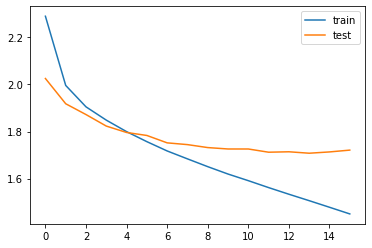

In [45]:
plt.plot(history.history['loss'] , label = 'train')
plt.plot(history.history['val_loss'] , label = 'test')
plt.legend()
plt.show()

#### build the dictionary to convert the index to word for target and source vocabulary:

In [63]:
reverse_target_word_index = y_tokeninzer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokeninzer.word_index

## Interface 

set up the inference for the encoder and decoder 

In [69]:
# Encode the input sequence to get the feature vector 

encoder_model = Model(inputs = encoder_inputs , outputs = [encoder_output3 , state_h3 , state_c3])

#Decoder setup 
#below tensors will hold the states of the previous time step 
decoder_state_input_h = Input(shape = (latent_dim , ))
decoder_state_input_c = Input(shape = (latent_dim , ))
decoder_hidden_state_input = Input(shape=(max_text_len , latent_dim))

#Get the embedding of the decoder sequence 

dec_emb2 = dec_emb_layer(decoder_inputs)
# to predict the next word in sequence , set initial states to the states from the previous time step

decoder_output2 , state_h2 , state_c2 = decoder_lstm(dec_emb2 , initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention interface 
attn_out_inf , attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_output2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_output2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [76]:
# defining a function below which is the implementation of the inference process (which we covered here):

def decode_sequence(input_seq):
    # encode the input as state vectors.
    e_out , e_h , e_c = encoder_model.predict(input_seq)
    
    #generate empty target sequence of length 1 
    target_seq = np.zeros((1,1))
    
    # populate the first word of target sequence with the start word
    target_seq[0,0] = target_word_index['sostok']
    
    stop_condition = False
    decoded_sentence = ' '
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [78]:
# Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

def seq2summery(input_seq):
    newString = ''
    for i in input_seq:
        if i!=0 and i!=target_word_index['sostok'] and i!=target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+ reverse_source_word_index[i]+' '
    return newString


In [79]:
for i in range(5,15):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summery(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")


Review: better teas twice cost one second purchase happy quality price paid buying item future 
Original summary: good tea money 
Predicted summary:   tea


Review: cats love food always lick every last love one best values high quality canned food 
Original summary: cats love 
Predicted summary:   cats love


Review: soy sauce best ever thanks amazon able find makes big difference using product thanks 
Original summary: best soy sauce ever 
Predicted summary:   best


Review: chips great pepper ones absolute favorite flavor reminds baked potato spicy cannot get enough bonus low fat calorie count munch without guilt deal 
Original summary: totally addicted chips 
Predicted summary:   great chips


Review: love beef teriyaki nuggets buffalo chicken nuggets rd kind eat great tasting easy eat love jack link nuggets line 
Original summary: tasty nuggets goodness 
Predicted summary:   great low carb snack


Review: liver treats love dachshund life nothing else comes close bought several sou

In [81]:
decode_sequence(x_tr[455].reshape(1,max_text_len))

'  great taste'